# TSIA202b - HR Methods - 

Guillaume C, Baptiste M

In [195]:
import os, sys, wave, struct

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import IPython

from copy import deepcopy
from math import ceil, exp, atan, pi, cos, sin
from scipy.io.wavfile import write
#import scipy.io.wavfile
from scipy.linalg import hankel
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import pylab as p
#import matplotlib.axes3d as p3
import mpl_toolkits.mplot3d.axes3d as p3

# Useful functions

In [196]:
def load_sound(file):
    return wave.open(file, 'rb')

def plot_sound(data, times,xlim1,xlim2,name='default_name', save=False,w=20,h=10, lw = 3):
    plt.figure(figsize=(w, h))
    plt.plot(times,x.reshape(len_x))
    plt.xlim(xlim1,xlim2)
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()
    
def read_values(filename):
    wave_file = wave.open(filename, 'r')
    nframes = wave_file.getnframes()
    nchannels = wave_file.getnchannels()
    sampling_frequency = wave_file.getframerate()
    T = nframes / float(sampling_frequency)
    read_frames = wave_file.readframes(nframes)
    wave_file.close()
    data = struct.unpack("%dh" %  nchannels*nframes, read_frames)
    
    data_per_channel = [data[offset::nchannels] for offset in range(nchannels)]
    return T, np.array(data_per_channel), nframes, nchannels, sampling_frequency

In [197]:
def Synthesis(N,delta,f,a,phi,RSB=False):
    t = range(N)
    logz = delta + 1j*2*np.pi*f
    alpha = a*np.exp(1j*phi)
    x = np.sum(np.outer(alpha, np.ones(N))*np.exp(np.outer(logz,t)), axis=0)
    if RSB == False: 
        s = x
    else: 
        Ex = np.real(np.sum(np.abs(x)**2))/N
        b = np.random.normal(size=N) + 1j*np.random.normal(size=N)
        Eb = np.real(np.sum(np.abs(b)**2))/N
        b = b*np.sqrt(Ex/Eb)*10**(-RSB/20)
        s = x+b    
    return s

# Open audio file

In [198]:
wavefile = load_sound('ClocheB.WAV')
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=8000, nframes=99414, comptype='NONE', compname='not compressed')


In [199]:
IPython.display.Audio('ClocheB.WAV')

In [200]:
T, data, nframes, nchannels, sampling_frequency = read_values('ClocheA.WAV')
Fs = int(wavefile.getframerate())
x = np.array(data)
num_samples = int(wavefile.getnframes())

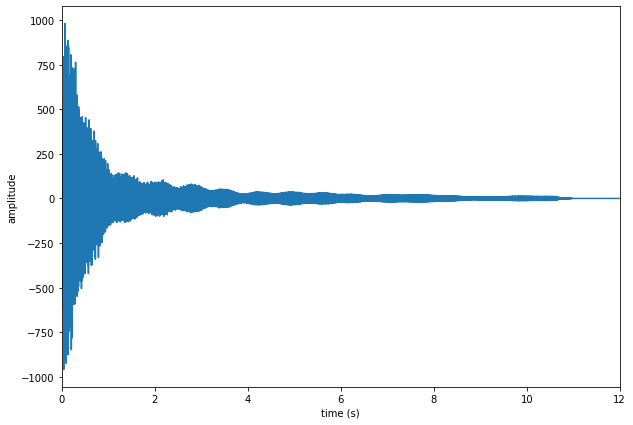

In [201]:
len_x = x.shape[1]
timestep = 1/(float(Fs))
times = np.arange(len_x)*timestep # int(len_x/6)
plot_sound(x.reshape(len_x), times,0,12,w=10,h=7)

In [202]:
write('new_bell.wav', Fs, np.array(x.reshape(len_x), dtype=np.int16)) # to write a new wave file

<h3> 3) Synthetic Signal. </h3>

In [203]:
phi = np.random.uniform(-np.pi, np.pi, (1,2))
print(phi)

[[-0.05362251 -1.19247759]]


In [204]:
N, f0, delta0, delta1 = 63, 1/4, 0, -0.05
f1, a0, a1 = f0 + 1/N, 1, 10
f, phi, a, delta = np.array([f0,f1]), np.array(phi), np.array([a0,a1]), np.array([delta0, delta1])

x = Synthesis(N,delta, f, a, phi)

In [205]:
def compute_periodogram(X_N, method="standard"):
    N = len(X_N)
    f = N 
    Nu_F = np.linspace(start=-0.5, stop=0.5, num=f)

    Exp_FN = np.exp(-2j* np.pi * Nu_F[:, None] * np.arange(0, N)[None])
    Sp_F = np.abs((X_N[None] * Exp_FN).sum(axis=-1)) ** 2
    Sp_F *=  N **(-1)

    return Nu_F, Sp_F

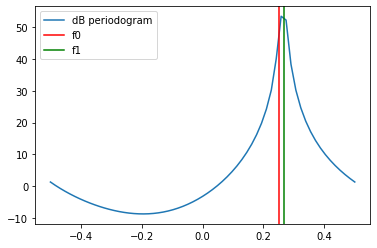

In [206]:
absc, periodo = compute_periodogram(x)

plt.figure()
plt.plot(absc, 20 * np.log10(periodo), label="dB periodogram")
plt.axvline(f0, c='red', label = 'f0')
plt.axvline(f1, c='green', label='f1')
plt.legend()
plt.show()

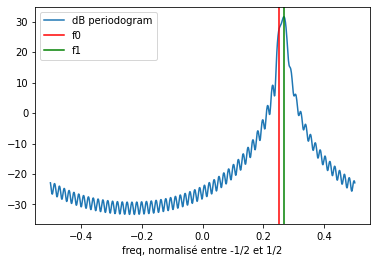

In [209]:
x_zeropad = np.concatenate((x,[0]*(1024-len(x))))
absc, periodo = compute_periodogram(x_zeropad)

plt.figure()
plt.plot(absc, 20 * np.log10(periodo), label="dB periodogram")
plt.axvline(f0, c='red', label = 'f0')
plt.axvline(f1, c='green', label='f1')
plt.xlabel('freq, normalisé entre -1/2 et 1/2')
plt.legend()
plt.show()

On devine un peu qu'il se passe quelque chose au pic, il n'est pas propre et on sent qu'il y a anguille sous roche mais on n'a pas exactement les bons pics, on n'est pas tout à fait sûrs. Nous sommes en réalité à la limite de la résolution. Même avec une plus grande précision, la résolution de Fourier ne suffit donc pas.

In [228]:
phi_ = np.random.uniform(-np.pi, np.pi, (1,2))

In [229]:
x = Synthesis(N,delta, f, a, phi_,20)

n, K = 32, 2
l = N-n+1
X = hankel(x[:n],x[n-1:N])

Rxx = X@X.conj() / np.shape(X)[1]
[U1,Lambda,U2] = np.linalg.svd(Rxx)
value, basis, i = Lambda[0], [], 0
eigens = []
while (value >1) and (i<len(Lambda)): #J'ai trouvé que 1 était un threshold correct pour différencier les valeurs propres correspondant à W le signal subspace et les "fausses" correspondant à W^T le noise subspace.
    print('Eigenvalue '+str(i)+' is : '+str(value)+'\n')
    eigens.append(value)
    basis.append(U1[:,i])
    i+=1
    value = Lambda[i]
W = np.array(basis).T #En fait, basis est tel que basis[0] contient le premier vecteur propre, et basis[1] le deuxième. Mais donc np.shape(basis) est (2,32), donc on transpose.
Eig = np.array(eigens)
print('Shape of the Hankel matrix :')
print(np.shape(X))
print('Shape of the eigenvectors matrix :')
print(np.shape(W)) #Basis of the SIGNAL subspace W, we didn't take any of the vectors corresponding to the NOISE subspace W^T which has the 0 eigenvalues. 

Eigenvalue 0 is : 428.04473060604766

Eigenvalue 1 is : 10.72063652100084

Shape of the Hankel matrix :
(32, 32)
Shape of the eigenvectors matrix :
(32, 2)


In [230]:
W_down, W_up = W[:-1,:], W[1:,:]
Phi = np.linalg.pinv(W_down) @ W_up
eigval, eigvec = np.linalg.eig(Phi)
deltaks = np.log(abs(eigval))
fks = np.angle(eigval)/(2*np.pi)
print("Ci-dessous les estimations de [delta1, delta0]")
print(deltaks)
print("Les vraies valeurs sont ["+str(delta1)+", "+str(delta0)+"].")
print("Ci-dessous les estimations de [f1, f0]")
print(fks)
print("Les vraies valeurs sont ["+str(f1)+", "+str(f0)+"].")

Ci-dessous les estimations de [delta1, delta0]
[-0.05053345 -0.00645798]
Les vraies valeurs sont [-0.05, 0].
Ci-dessous les estimations de [f1, f0]
[0.26605608 0.2499234 ]
Les vraies valeurs sont [0.26587301587301587, 0.25].


On peut être assez content de nos estimations ! On retrouve parfaitement les f_ks et les delta_ks, à 0.001 près, sauf peut-être pour delta0 qui est un peu grand pour une valeur qui devrait être au plus près de zéro, mais c'est aussi le 'bruit' qui rentre en compte, le fait qu'on a quand même coupé assez haut les valeurs propres (mêmes si on a bien les deux principales à 300 et 10, les suivantes étant à 1 ou moins...).

<h3> 4) Estimation of amplitudes and phases. </h3>

In [231]:
#Vander fait à la main avec l'astuce du TP
tvec = np.array(range(N))   #L'array colonne (à gauche dans le produit des vecteurs a.T @ b) des t dans {0,1...N-1}
inexpv = np.array([deltaks[k] +2j*np.pi*fks[k] for k in range(K)]) #l'array ligne des deltaks (facteur de décroissance) + 2j_pi_fk (facteur de phase) à droite dans le produit a.T @ b
tvec = tvec.reshape((N,1))
inexpv = inexpv.reshape((1,K))
#print(np.shape(tvec))   (63,1)
#print(np.shape(inexpv)) (1,2)
lnVander =  np.dot(tvec,inexpv)
V = np.exp(lnVander)
print(V[:5,:])

[[ 1.00000000e+00+0.00000000e+00j  1.00000000e+00+0.00000000e+00j]
 [-9.57494103e-02+9.45888270e-01j  4.78171016e-04+9.93562715e-01j]
 [-8.85536670e-01-1.81136488e-01j -9.87166639e-01+9.50185785e-04j]
 [ 2.56124493e-01-8.20275038e-01j -1.41610364e-03-9.80811512e-01j]
 [ 7.51364767e-01+3.20806005e-01j  9.74497071e-01-1.87598342e-03j]]


In [232]:
#Cette cellule contient la version utilisant la fonction np.vander de numpy, la cellule au-dessus contient le code avec l'astuce du TP (produit scalaire de colonne * ligne).
#A noter que la fonction vander ne fait pas exactement la matrice de Vandermonde et qu'il faut la corriger, cf mon code. En gros, il faut la symétriser par rapport à l'horizontale.
"""
V = np.vander(eigval, N).T
for i in range(31):  #Transposition à la main pour corriger les erreurs de np.vander, symétrisation horizontale (bas <-> haut)
    V[i,0],V[62-i,0] = V[62-i,0],V[i,0]
    V[i,1],V[62-i,1] = V[62-i,1],V[i,1]
"""

'\nV = np.vander(eigval, N).T\nfor i in range(31):  #Transposition à la main pour corriger les erreurs de np.vander, symétrisation horizontale (bas <-> haut)\n    V[i,0],V[62-i,0] = V[62-i,0],V[i,0]\n    V[i,1],V[62-i,1] = V[62-i,1],V[i,1]\n'

In [233]:
alpham = np.linalg.pinv(V)@x[:N]
aks = np.abs(alpham)
phiks = np.angle(alpham)
print('Les ak trouvés sont')
print(aks)
print('Les vrais ak sont')
print('['+str(a1)+', '+str(a0)+']\n')
print('Et les phik trouvés sont')
print('['+str(phiks[1])+', '+str(phiks[0])+']\n')
print('Les vrais phik sont')
print(phi_)

Les ak trouvés sont
[10.09928247  1.29104601]
Les vrais ak sont
[10, 1]

Et les phik trouvés sont
[2.302696934690758, 0.4696830193367181]

Les vrais phik sont
[[0.51257982 2.19095524]]


On retrouve notamment a1 et a0 à 10 et 1 environ (10.16 et 1.07), les autres ak seraient bien plus bas donc on a quand même identifié deux amplitudes pour les deux fréquences majoritaires que l'on cherchait. On retrouve également les phik que nous avions générés aléatoirement, à environ 0.05 de différence (sur une plage de -pi à pi, c'est plus que bien).
</br> On peut donc être assez content de nos résultats, et conclure que la méthode ESPRIT (et LeastSquare) fonctionnent bien. 

Tout ce qui a été fait au-dessus est hard-codé, c'est-à-dire utilisable une fois et avec seulement les valeurs que j'ai rentrées. Maintenant, comme j'en ai besoin pour MUSIC, je code tout avec des fonctions proprement :

In [234]:
def ESPRIT(x,n,l,K):
    
    #Calcul des matrices nécessaires
    X = hankel(x[0:n], x[n-1:])
    Rxx_emp = X @ X.conj().T / l
    U, S, V = np.linalg.svd(Rxx_emp)
    W = U[:,:K]
    
    #Extraction de Wup et Wdown pour la méthode ESPRIT
    W_down, W_up = W[:-1,:], W[1:,:]
    Phi = np.linalg.pinv(W_down) @ W_up
    eigval, eigvec = np.linalg.eig(Phi)
    eigvalSorted = np.sort(eigval)
    
    #Now we extract delta (dampening factors) and freqs
    fs = np.angle(eigvalSorted) / (2*np.pi)
    deltas = np.log(np.abs(eigvalSorted))
    
    return fs, deltas

In [238]:
def leastSquares(X, fs, deltas):
    N = len(X)
    V = np.vander(np.exp(deltas + 2j*np.pi*fs), N=N, increasing=True).T
    #J'ai grâce à un camarade trouvé entre temps la solution pour faire fonctionner vander : increasing = True
    alpham = np.linalg.pinv(V) @ X
    return np.abs(alpham), np.angle(alpham)

In [240]:
n,l,K = 32, N-n+1, 2
f, delta = ESPRIT(x, n, l, K)
a, phi = leastSquares(x, f, delta)

print('Les ak trouvés sont')
print(a)
print('Les vrais ak sont')
print('['+str(a1)+', '+str(a0)+']\n')
print('Et les phik trouvés sont')
print('['+str(phi[0])+', '+str(phi[1])+']')
print('Les vrais phik sont')
print(phi_)

Les ak trouvés sont
[10.09928247  1.29104601]
Les vrais ak sont
[10, 1]

Et les phik trouvés sont
[0.4696830193367173, 2.302696934690759]
Les vrais phik sont
[[0.51257982 2.19095524]]


<h3> 6. MUSIC Pseudo-spectrum </h3>

In [244]:
def MUSIC(x,n,l,K,Zvec):
    
    #Calcul des matrices nécessaires
    X = hankel(x[0:n], x[n-1:])
    Rxx_emp = X @ X.conj().T / l
    U, S, V = np.linalg.svd(Rxx_emp)
    WT = U[:,K:n]
    
    V = np.vander(Zvec, N=n, increasing=True).T #Encore une fois on n'oublie pas le increasing
    prod = WT.conj().T @ V
    return 1/np.linalg.norm(prod, axis=0)**2 #Le carré pourrait déjà être compris dans norm, mais ça ne change pas le résultat

In [255]:
N=63
n=32
l=N-n+1
K=2
MUSIC(x, n, l, K, [np.exp(delta0 + 2j*np.pi*f0), np.exp(delta1 + 2j*np.pi*f1)])

array([ 13.24259553, 272.63378154])

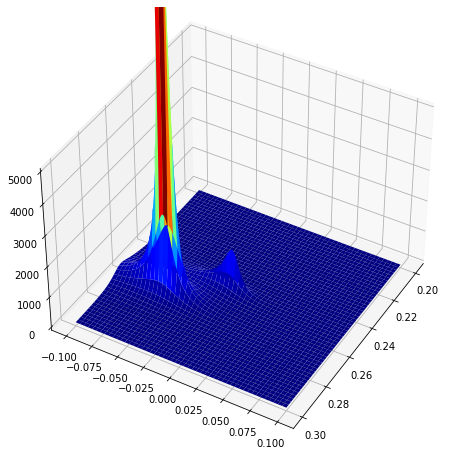

In [258]:
fs = np.linspace(0.2,0.3,1000)
deltas = np.linspace(-0.1,0.1,1000)

fabs, dabs = np.meshgrid(fs, deltas)
Z = MUSIC(x,n,l,K, np.exp(dabs + 2j*np.pi*fabs).reshape(-1)).reshape((1000,1000)) #A nouveau cette idée de dérouler et réenrouler me vient d'un camarade

#Cuisine python :
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8,8))
surf = ax.plot_surface(fabs,dabs,Z*50,cmap='jet') #le *50 pour afficher plus largement les pics

ax.axes.set_zlim3d(bottom=0, top=5000)
ax.view_init(40,30)
plt.show()
#On devine les pics ! 

Les pics se trouvent à peu près en (delta, f) = (0,0.25) et (-0.05,0.265).</br>
Cela correspond à une bonne estimation des paramètres.

 <h3>Dernière partie : application </h3>

Je remercie L. Personnaz pour son aide.

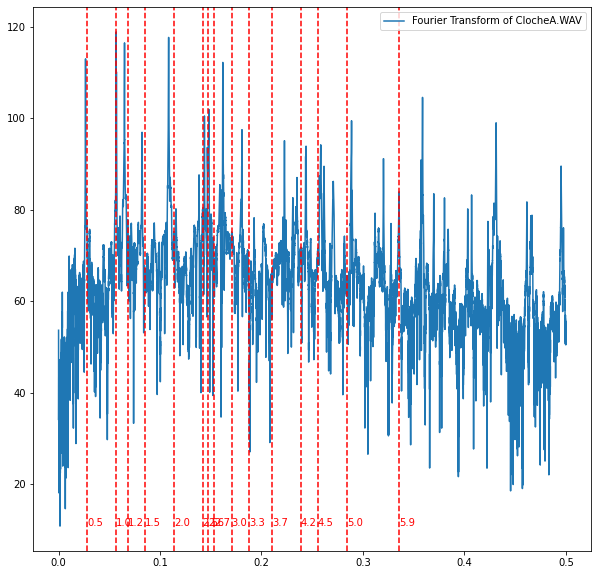

In [285]:
T, data, n_frames, n_channels, Fs = read_values("ClocheA.WAV")
f_t = np.fft.fft(data[0])
N = len(f_t)
epsilon = 0.000000001
Y = 20 * np.log10(np.abs(np.roll(f_t, N//2)) + epsilon)

fig = plt.figure(figsize = (10,10))

freq0 = np.argpartition(np.abs(f_t[:N//2]), -1)[-1] / N
nus = np.linspace(0, 0.5, N-N//2)
    
bellfreq = np.array([0.5,1,1.2,1.5,2,2.5,2.6,2.7,3,3.3,3.7,4.2,4.5,5,5.9])
harmo_freq = N * (0.5 + freq0 * bellfreq)
    
plt.plot(nus, Y[N//2:N], label="Fourier Transform of ClocheA.WAV")
    
for pseudo_harmonic in bellfreq:
    freq = freq0*pseudo_harmonic
    if (freq > 0) & (freq < 0.5):
        plt.axvline(freq,  linestyle='--',color='red')
        plt.text(freq, np.min(Y), pseudo_harmonic, color='red')
plt.legend()
plt.show()

Il y a un léger décalage sur certain mais il est vraiment faible, et le nombre est bon. Les barettes rouges sont souvent bien alignées avec les harmoniques !

In [295]:
from scipy.io.wavfile import write

In [299]:
T, data, n_frames, n_channels, Fs = read_values("ClocheA.WAV")

#Après plusieurs tests, il faut éviter de prendre en compte le début de la waveform
#il y a un maximum, un pic au début qui embête l'écoute du reste
#De plus ça prend beaucoup de temps donc je ne coupe qu'une partie de la data :
x = data.flatten()[1000:10000]
N = len(x)

#Valeurs de l'énoncé :
K,n,l = 54,N//3,N-n+1

#Application du TP :
f, delta = ESPRIT(x, n, l, K)
a, phi = leastSquares(x, f, delta)
newBellA = Synthesis(N, delta, f, a, phi)
write("newBellA.wav", Fs, 100 * np.array(np.real(newBellA)).astype(np.int16))


A part sur ce début de son très désagréable, très bruité (1000 premiers samples que j'ai évincés), le son ressemble beaucoup à l'original !

In [ ]:
#Guillaume C et Baptiste M
#Il faut noter pour cette dernière question la présence d'un pic de bruit très désagréable
#je l'ai donc coupé avec le slicing sur mon flatten.